# Reproducing the topological Anderson insulator

## Import libraries

In [4]:
import kwant
import kwant.continuum
import scipy.sparse.linalg
import scipy.linalg
import numpy as np

import pybinding as pb

import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams.keys()
plt.rcParams.update({'figure.figsize':(10,10),
                     'font.size':25})


import os.path
def save_image(name):
    folder = "./figures/"
    if os.path.exists(folder + name + ".png"):
        raise Exception("File already exist")
        return 0
    
    plt.savefig(folder + name + ".png", dpi=300)

## Define functions

In [5]:
# make system
def make_model(l_x, a=5, l_y=500):
    # continous hamiltonian
    hamiltonian = """
       + C * identity(4) + M * kron(sigma_0, sigma_z)
       - B * (k_x**2 + k_y**2) * kron(sigma_0, sigma_z)
       - D * (k_x**2 + k_y**2) * kron(sigma_0, sigma_0)
       + A * k_x * kron(sigma_z, sigma_x)
       - A * k_y * kron(sigma_0, sigma_y)
    """

    # make discretized template
    template = kwant.continuum.discretize(hamiltonian, grid=a)
    lat = template.lattice
    #print(template)
    
    # define shape of system
    def shape(site):
        (x, y) = site.pos
        return (0 <= y < l_y and 0 <= x < l_x)

    # define lead shape
    def lead_shape(site):
        (x, y) = site.pos
        return (0 <= y < l_y)

    # make system
    syst = kwant.Builder()
    # fill according to the hamiltonian
    syst.fill(template, shape, (0, 0))

    # attach leads
    lead = kwant.Builder(kwant.TranslationalSymmetry([-a, 0]))
    lead.fill(template, lead_shape, (0, 0))

    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())

    # finalize system
    #syst = syst.finalized()
    return syst, lat





# advanced system builder
def make_syst3(syst, lat, n_x, n_y):
    # original function of onsite energies
    onsite_func = syst[lat(0,0)]

    # my function for onsite energies
    def my_onsite_func(site, B, C, D, M, W):
        rand = np.random.uniform(low=-W/2, high=W/2)
        rand_matrix = np.array([[rand,0,0,0],
                                [0,rand,0,0], 
                                [0,0,rand,0], 
                                [0,0,0,rand]])
        return rand_matrix + onsite_func(site, params['B'], params['C'], params['D'], params['M'])

    # iterate over every element of the system and add my onsite function
    for i in range(0,n_x):
        for j in range(0,n_y):
            syst[lat(i,j)] = my_onsite_func
            
    return syst

## Define the systems and parameters

In [6]:
params = dict(A=0.3645, B=-0.686, D=-0.512, M=-0.010, C=0) # inverted
params2 = dict(A=0.3645, B=-0.686, D=-0.512, M=0.000, C=0) # between inverted and normal
params3 = dict(A=0.3645, B=-0.686, D=-0.512, M=0.002, C=0) # normal for band structure
params4 = dict(A=0.3645, B=-0.686, D=-0.512, M=0.001, C=0) # normal for sym
params5 = dict(A=0.3645, B=-0.686, D=-0.512, M=-0.010, C=0, W=0) # disordered inverted
params6 = dict(A=0.3645, B=-0.686, D=-0.512, M=0.001, C=0, W=0) # disordered normal for sym

syst, lat = make_model(l_y=2000, l_x=2000)
syst = syst.finalized()

syst2, lat2 = make_model(l_x=2000)
print(syst2[lat2(0,0)])
syst2 = syst2.finalized()

syst3, lat3 = make_model(l_x=5000)
syst3 = make_syst3(syst3, lat3, n_x=400, n_y=100)
print(syst3[lat3(0,0)])
syst3 = syst3.finalized()


<function onsite at 0x7f9477ac6b70>
<function make_syst3.<locals>.my_onsite_func at 0x7f94a6a6cd08>


## Show system

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
_ = kwant.plot(syst3, ax=ax)

#save_image("arcticleone.system")
plt.show()

fig, ax = plt.subplots(1,1, figsize=(20,10))
_ = kwant.plot(syst3, ax=ax)

plt.xlim(0,100)
plt.ylim(0,100)

#save_image("arcticleone.system")
plt.show()


## Plot band structure

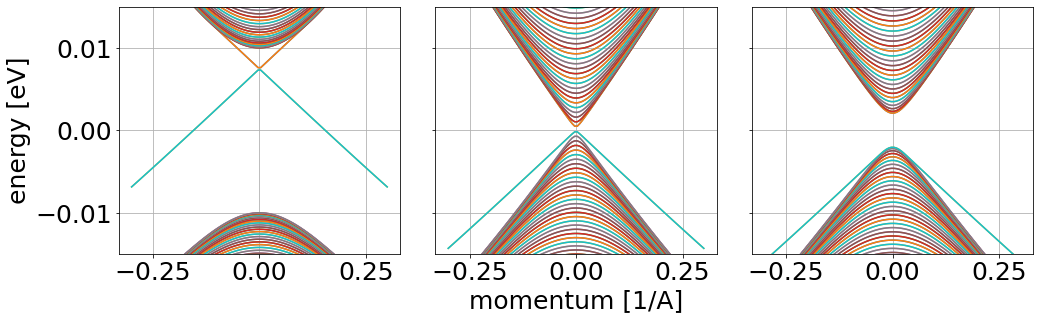

In [43]:
fig, ax = plt.subplots(1,3, figsize=[15,5], sharex=True, sharey=True)

kwant.plotter.bands(syst.leads[0], params=params,
                    momenta=np.linspace(-0.3, 0.3, 100), ax=ax[0])
kwant.plotter.bands(syst.leads[0], params=params2,
                    momenta=np.linspace(-0.3, 0.3, 100), ax=ax[1])
kwant.plotter.bands(syst.leads[0], params=params3,
                    momenta=np.linspace(-0.3, 0.3, 100), ax=ax[2])


ax[0].set_ylim(-0.015, 0.015)
ax[1].set_xlabel('momentum [1/A]')
ax[0].set_ylabel('energy [eV]')

ax[0].grid()
ax[1].grid()
ax[2].grid()
plt.tight_layout()

save_image("arcticletwo.good_bands")

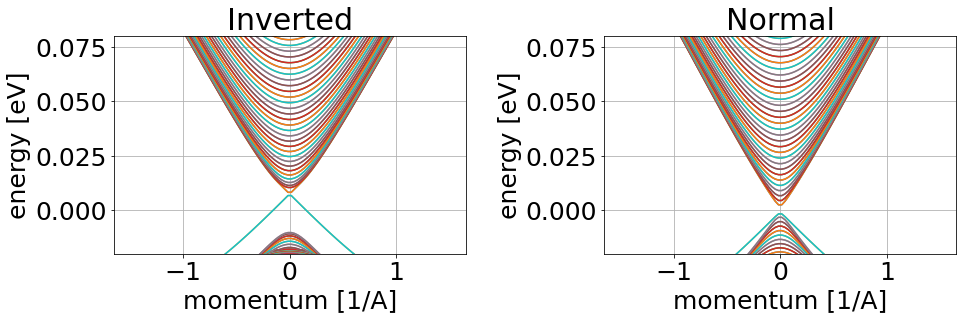

In [44]:
fig, ax = plt.subplots(1,2, figsize=[14,5])

kwant.plotter.bands(syst3.leads[0], params=params5,
                    momenta=np.linspace(-1.5, 1.5, 100), ax=ax[0])
kwant.plotter.bands(syst3.leads[0], params=params6,
                    momenta=np.linspace(-1.5, 1.5, 100), ax=ax[1])


ax[0].set_title("Inverted")
ax[0].set_ylim(-0.020, 0.080)
ax[0].set_xlabel('momentum [1/A]')
ax[0].set_ylabel('energy [eV]')
ax[0].grid()

ax[1].set_title("Normal")
ax[1].set_ylim(-0.020, 0.080)
ax[1].set_xlabel('momentum [1/A]')
ax[1].set_ylabel('energy [eV]')
ax[1].grid()

plt.tight_layout()
save_image("arcticletwo.good_bands_2")


## Number of open channels

def number_of_open(syst, lead, threshold):
    momenta = np.linspace(-np.pi, np.pi, 500)
    bands = kwant.physics.Bands(syst.leads[lead])
    energies = np.array([bands(k) for k in momenta]).T


    open_channel = []
    for i, band in enumerate(energies):
        if (band < threshold).any():
            if (band > threshold).any():
                open_channel.append(i)

    return open_channel



len(number_of_open(model.tokwant(), 0, 2))

## Compute the conductance at zero disorder and varying energy

In [17]:
# Compute conductance
energies = np.linspace(-0.030,0.080,100)
data1 = []
data2 = []

# iterating over well depths
for i, energy in enumerate(energies):    
    # calculate the scattering matrix
    smatrix1 = kwant.smatrix(syst2, energy, params=params)
    smatrix2 = kwant.smatrix(syst2, energy, params=params4)
    
    # calculate the trensmission betweeen two leads
    data1.append(smatrix1.transmission(1, 0))
    data2.append(smatrix2.transmission(1, 0))
    print(i)

data1 = np.array(data1)
data2 = np.array(data2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [32]:
#np.savetxt("./article_two_data/data1_100.txt", data1)
#np.savetxt("./article_two_data/data2_100.txt", data2)


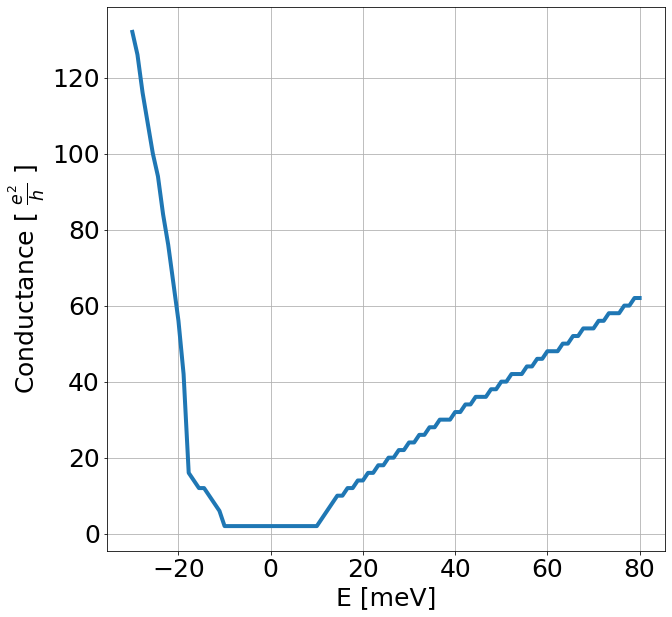

In [21]:
plt.figure(figsize=(10,10))
plt.plot(energies*1000, data1, linewidth=4)
plt.xlabel("E [meV]")
plt.ylabel(r'Conductance [ $\frac{e^2}{h}$ ]')
#plt.figtext(.15, .2, r'energy: %.2f, number of open channels: %d' %(energy, len(open_channels2)))

plt.grid()
fig.tight_layout()
#save_image("arcticlerwo.c")


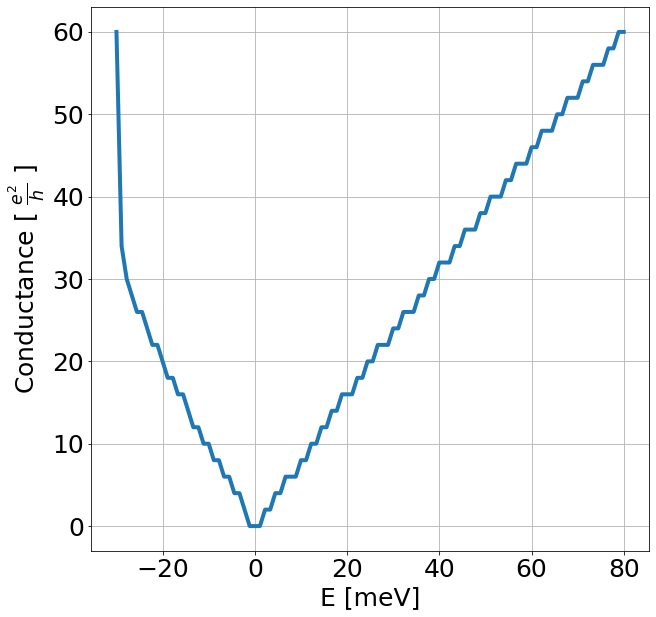

In [22]:
plt.figure(figsize=(10,10))
plt.plot(energies*1000, data2, linewidth=4)
plt.xlabel("E [meV]")
plt.ylabel(r'Conductance [ $\frac{e^2}{h}$ ]')
#plt.figtext(.15, .2, r'energy: %.2f, number of open channels: %d' %(energy, len(open_channels2)))

plt.grid()
fig.tight_layout()
#save_image("arcticlerwo.f")


## Compute the conductance at fixed energy and varying disorder

In [45]:
# Compute conductance
energy = 0.009
disorder = np.logspace(0,np.log10(400),50) * 0.001 # from 0 to 400 meV
data3 = np.empty(len(disorder))
#data4 = np.empty(len(disorder))
average = 5

for j in range(average):
    data3_curr = []
    #data4_curr = []
    # iterating over disorder
    for i, W in enumerate(disorder):
        # update disorder parameter
        params5['W'] = W
        #params6['W'] = W

        # calculate the scattering matrix
        smatrix3 = kwant.smatrix(syst3, energy, params=params5)
        #smatrix4 = kwant.smatrix(syst3, energy, params=params6)

        # calculate the transmission betweeen two leads
        data3_curr.append(smatrix3.transmission(1, 0))
        #data4_curr.append(smatrix4.transmission(1, 0))
        print(i)

    data3 = np.vstack([data3, data3_curr])
    #data4 = np.vstack([data4, data4_curr])
    
data3 = np.delete(data3, 0, axis=0)
#data4 = np.delete(data4, 0, axis=0)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [7]:
#np.savetxt("./article_two_data/data3_5_50_e9.txt", data3)
#np.savetxt("./article_two_data/data4_5_50_e-174.txt", data4)
e9 = np.loadtxt("./article_two_data/data3_5_50_e9.txt")
e174 = np.loadtxt("./article_two_data/data3_5_50_e-174.txt")
e10 = np.loadtxt("./article_two_data/data3_10_50.txt")
dat41 = np.loadtxt("./article_two_data/data4_10_50.txt")
dat42 = np.loadtxt("./article_two_data/data4_5_50_e-174.txt")


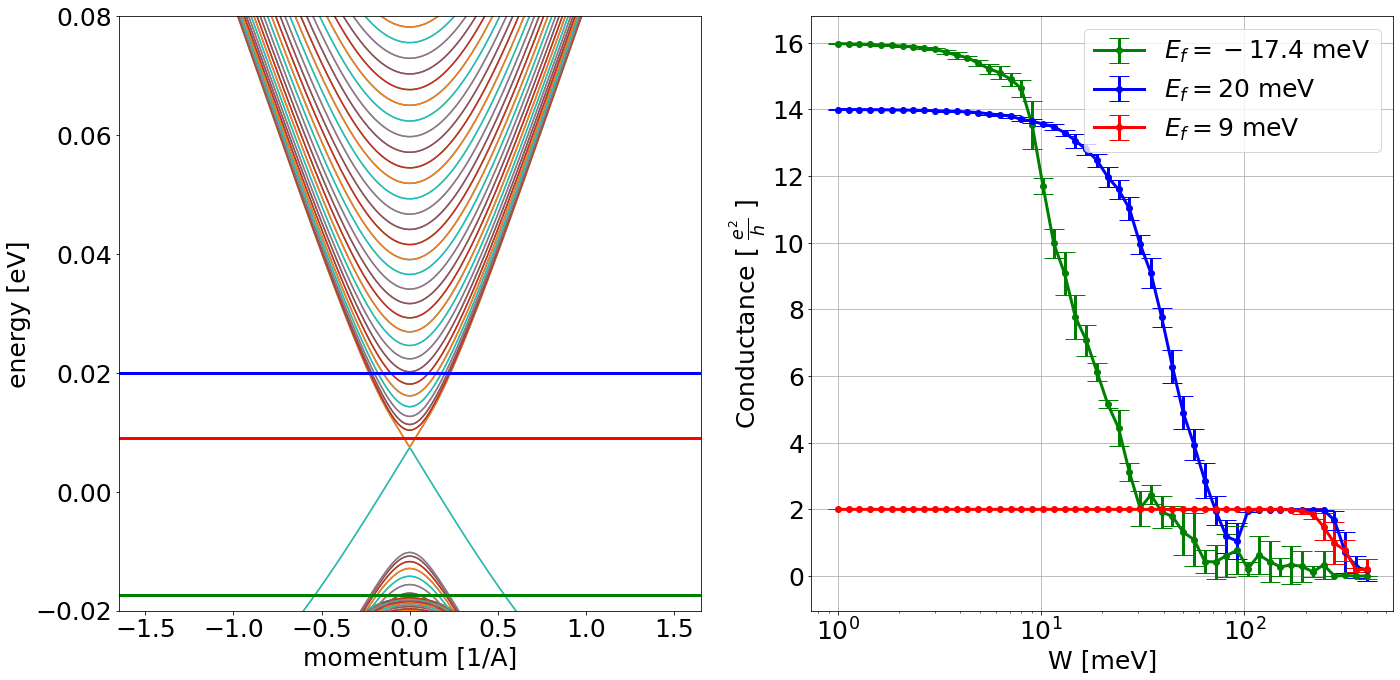

In [10]:
fig, ax = plt.subplots(1,2, figsize=[20,10])

kwant.plotter.bands(syst3.leads[0], params=params5,
                    momenta=np.linspace(-1.5, 1.5, 500), ax=ax[0])

ax[0].axhline(0.009, linewidth=3, c='r')
ax[0].axhline(-0.0174, linewidth=3, c='g')
ax[0].axhline(0.020, linewidth=3, c='b')

#ax[0].set_title("Inverted")
ax[0].set_ylim(-0.020, 0.080)
ax[0].set_xlabel('momentum [1/A]')
ax[0].set_ylabel('energy [eV]')
#ax[0].grid()


ax[1].errorbar(disorder*1000, e174.mean(axis=0), yerr=e174.std(axis=0), linewidth=3, marker="o", capsize=10, c='g', label=r'$E_f = -17.4$ meV')
ax[1].errorbar(disorder*1000, e10.mean(axis=0), yerr=e10.std(axis=0), linewidth=3, marker="o", capsize=10, c='b', label=r'$E_f = 20$ meV')
ax[1].errorbar(disorder*1000, e9.mean(axis=0), yerr=e9.std(axis=0), linewidth=3, marker="o", capsize=10, c='r', label=r'$E_f = 9$ meV')

ax[1].set_xlabel("W [meV]")
ax[1].set_ylabel(r'Conductance [ $\frac{e^2}{h}$ ]')

ax[1].set_xscale('log')

plt.legend()
plt.grid()
fig.tight_layout()
#save_image("arcticlerwo.disorder")
plt.savefig("anderson1.png")


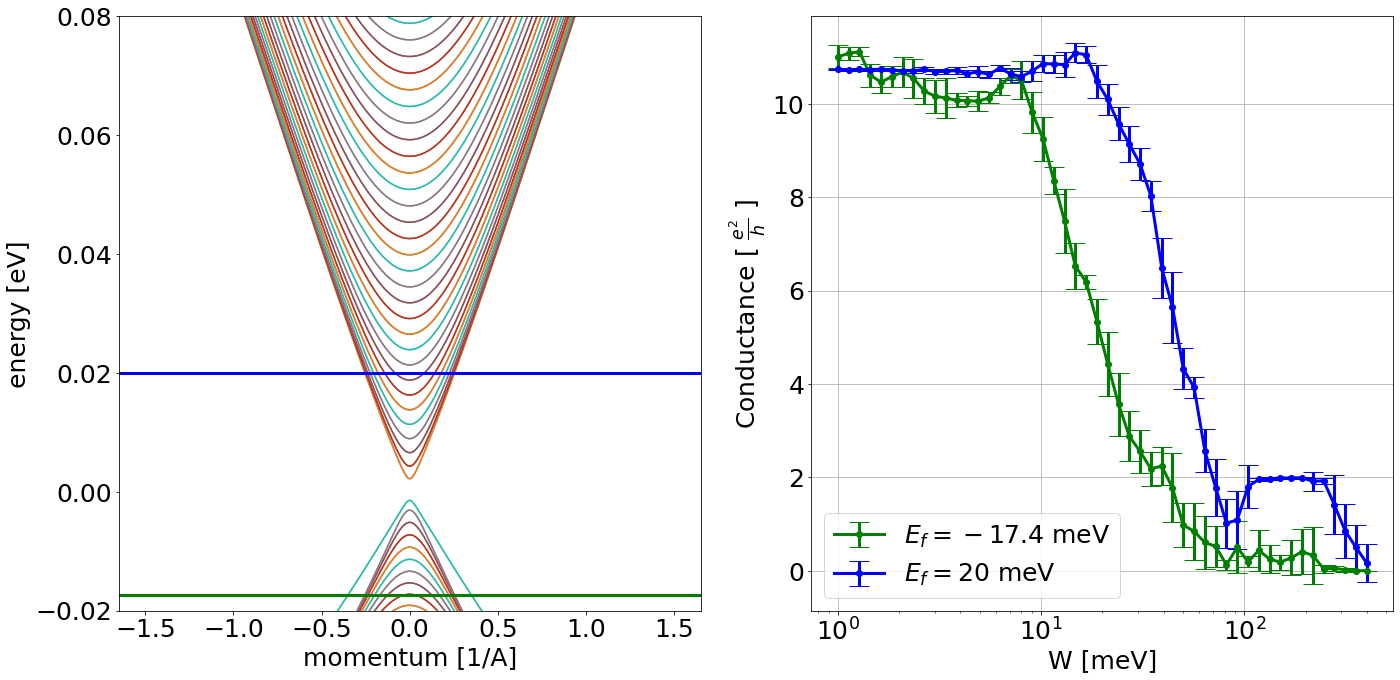

In [11]:
fig, ax = plt.subplots(1,2, figsize=[20,10])

kwant.plotter.bands(syst3.leads[0], params=params6,
                    momenta=np.linspace(-1.5, 1.5, 500), ax=ax[0])

ax[0].axhline(-0.0174, linewidth=3, c='g')
ax[0].axhline(0.020, linewidth=3, c='b')

#ax[0].set_title("Inverted")
ax[0].set_ylim(-0.020, 0.080)
ax[0].set_xlabel('momentum [1/A]')
ax[0].set_ylabel('energy [eV]')
#ax[0].grid()


ax[1].errorbar(disorder*1000, dat42.mean(axis=0), yerr=dat42.std(axis=0), linewidth=3, marker="o", capsize=10, c='g', label=r'$E_f = -17.4$ meV')
ax[1].errorbar(disorder*1000, dat41.mean(axis=0), yerr=dat41.std(axis=0), linewidth=3, marker="o", capsize=10, c='b', label=r'$E_f = 20$ meV')

ax[1].set_xlabel("W [meV]")
ax[1].set_ylabel(r'Conductance [ $\frac{e^2}{h}$ ]')

ax[1].set_xscale('log')

plt.legend()
plt.grid()
fig.tight_layout()
#save_image("arcticlerwo.disorder")
plt.savefig("anderson2.png")


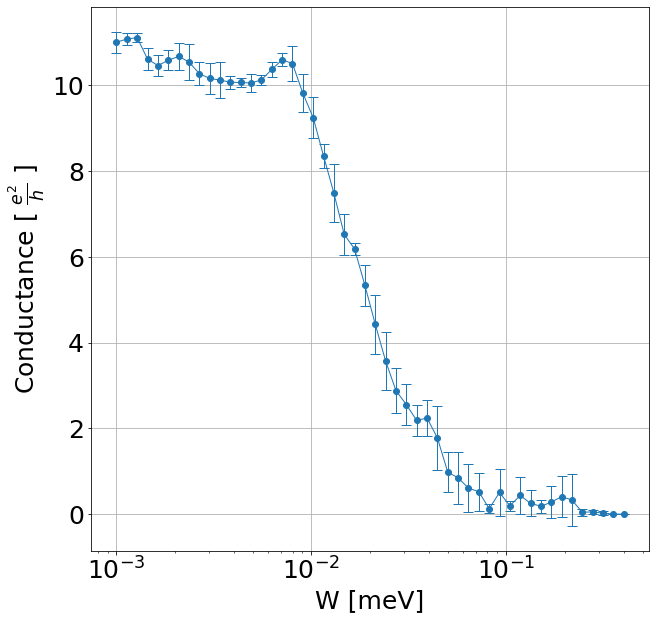

In [48]:
plt.figure(figsize=(10,10))
plt.errorbar(disorder, data4.mean(axis=0), yerr=data4.std(axis=0), linewidth=1, marker="o", capsize=5)

plt.xlabel("W [meV]")
plt.ylabel(r'Conductance [ $\frac{e^2}{h}$ ]')

plt.xscale('log')

plt.grid()
fig.tight_layout()
#save_image("arcticlerwo.disorder")
